# Import Modules

In [1]:
import sys

sys.path.insert(0, '../input/computer-vision-training-fcis-21/')

import utils

working_dir = '../input/computer-vision-training-fcis-21/224/content/flowers/224/'

train_dir = f'{working_dir}/train/train/'
test_dir = f'{working_dir}/test/test/'

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

import matplotlib.pyplot as plt

from tqdm import tqdm

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Read N-Batches

In [3]:
train_nbatch = utils.num_of_batches(train_dir + '/origin')

print('No. Batches: %i'%train_nbatch)

No. Batches: 108


In [4]:
start = 0
end = 107

xdata = utils.read_nbatch(train_dir + '/origin', start, end)
ydata = utils.read_nbatch(train_dir + '/masks', start, end)

print(xdata['x'].shape, ydata['x'].shape)

100%|██████████| 106/106 [00:09<00:00, 10.66it/s]

(6848, 224, 224, 3) (6848, 224, 224)


# Explore

In [5]:
def plot(images: np.ndarray, nrows: int = 1, ncols: int = 4, figsize: tuple = (10, 6)):

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    
    axs = axs.flatten()

    for i in range(len(axs)):

        axs[i].imshow(images[i].squeeze())

        axs[i].grid(None)
        axs[i].axis('off')
    
    
    fig.tight_layout()
    
    return fig, axs

In [6]:
def sample(images, sample_size=4, random_state=42):
    
    random = np.random.RandomState(random_state)

    indices = np.arange(0, 320)

    random.shuffle(indices)
    
    indices = indices[:sample_size]    
    
    return images[indices]

In [7]:
x_sample = sample(xdata['x'])
y_sample = sample(ydata['x'])

print(x_sample.shape, y_sample.shape)

(4, 224, 224, 3) (4, 224, 224)


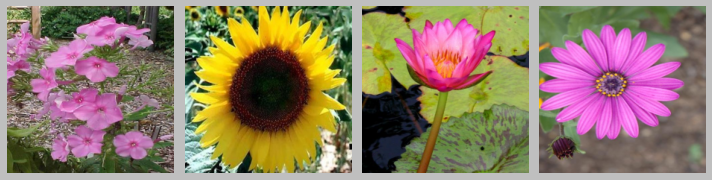

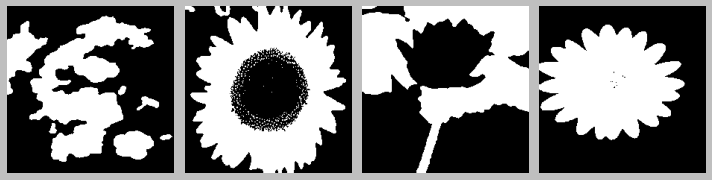

In [8]:
plt.style.use('grayscale')

fig, ax = plot(x_sample)
fig, ax = plot(y_sample)

# Model

In [9]:
import tensorflow as tf

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, losses, metrics

2021-09-23 16:16:56.615347: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [10]:
 inputs = Input(shape=(224, 224, 3))


conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
conv1 = BatchNormalization()(conv1)
pool1 = MaxPooling2D((2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
conv2 = BatchNormalization()(conv2)
pool2 = MaxPooling2D((2, 2))(conv2)


conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
conv3 = BatchNormalization()(conv3)
pool3 = MaxPooling2D((2, 2))(conv3)

conv00 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv00 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv00)
conv00 = BatchNormalization()(conv00)



deconv0= Conv2DTranspose(128, (3, 3), strides=(2, 2), padding="same")(conv00)
up0 = concatenate([deconv0, conv3])
conv0 = Conv2D(128, (3, 3), activation='relu', padding='same')(up0)
conv0 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv0)
conv0 = BatchNormalization()(conv0)

deconv1 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same")(conv0)
up1 = concatenate([deconv1, conv2])
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
conv4 = BatchNormalization()(conv4)

deconv2 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding="same")(conv4)
up2 = concatenate([deconv2, conv1])
conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2)
conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)

conv5 = Conv2D(2, (3, 3), activation='relu', padding='same')(conv5)
conv5 = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(conv5)



outputs = Reshape(target_shape=(224, 224))(conv5)
model = Model(inputs, outputs)

optimizer = optimizers.Adam(learning_rate=1e-3)
loss = losses.BinaryCrossentropy('loss')
metric = metrics.MeanIoU(2, name='iou')

model.compile(optimizer=optimizer, loss=loss, metrics=metric)

2021-09-23 16:17:00.424962: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-23 16:17:00.428174: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-23 16:17:00.465372: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-23 16:17:00.466002: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-09-23 16:17:00.466055: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-09-23 16:17:00.488832: I tensorflow/stream_executor/platform/def

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 32) 128         conv2d_1[0][0]                   
______________________________________________________________________________________________

In [12]:
model.fit(xdata['x'], ydata['x'], epochs=10, batch_size=64)

2021-09-23 16:17:02.763105: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1030815744 exceeds 10% of free system memory.
2021-09-23 16:17:03.978905: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-23 16:17:03.989862: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000189999 Hz


Epoch 1/10


2021-09-23 16:17:05.851340: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2021-09-23 16:17:11.096428: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-09-23 16:17:11.846149: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


107/107 [==============================] - 59s 432ms/step - loss: 0.6424 - iou: 0.4538
Epoch 2/10
107/107 [==============================] - 46s 433ms/step - loss: 0.5903 - iou: 0.6743
Epoch 3/10
107/107 [==============================] - 46s 434ms/step - loss: 0.5891 - iou: 0.7245
Epoch 4/10
107/107 [==============================] - 46s 433ms/step - loss: 0.5876 - iou: 0.6986
Epoch 5/10
107/107 [==============================] - 46s 434ms/step - loss: 0.5869 - iou: 0.6847
Epoch 6/10
107/107 [==============================] - 46s 433ms/step - loss: 0.5862 - iou: 0.6671
Epoch 7/10
107/107 [==============================] - 46s 434ms/step - loss: 0.5863 - iou: 0.6843
Epoch 8/10
107/107 [==============================] - 46s 434ms/step - loss: 0.5838 - iou: 0.7054
Epoch 9/10
107/107 [==============================] - 46s 434ms/step - loss: 0.5844 - iou: 0.6800
Epoch 10/10
107/107 [==============================] - 46s 433ms/step - loss: 0.5847 - iou: 0.7121


# Predict

In [13]:
test_nbatches = utils.num_of_batches(test_dir + '/origin')

print('No. Batches: %i'%test_nbatches)

No. Batches: 20


In [14]:
test_data = utils.read_nbatch(test_dir + 'origin/', 108, 108 + test_nbatches)

test_size = len(test_data['id'])

print(test_size)

100%|██████████| 19/19 [00:03<00:00,  4.83it/s]

1277


In [15]:
test_ids = test_data['id']

test_masks = model.predict(test_data['x']) > 0.5

In [16]:
x_sample = sample(test_data['x'])
y_sample = sample(test_masks)

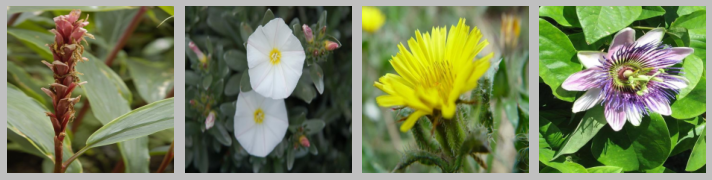

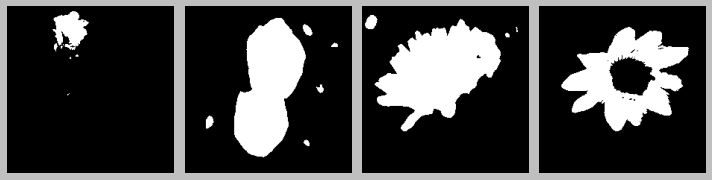

In [17]:
plt.style.use('grayscale')

fig, ax = plot(x_sample)
fig, ax = plot(y_sample)

# Submission

In [18]:
submission = utils.Submission(shape=(224, 224))

submission.init()

for i in tqdm(range(test_size)):
    
    submission.update(test_ids[i], test_masks[i])

100%|██████████| 1277/1277 [00:04<00:00, 296.74it/s]


In [19]:
submission.export('submission.csv')